# rstoolbox - a Python library for large-scale analysis of computational protein design data and structural bioinformatics

[![bioRxiv](https://img.shields.io/badge/bioRxiv%20preprint-doi.org/10.1101/428045-blue.svg)](https://doi.org/10.1101/428045)

[![BMC Bioinformatics](https://img.shields.io/badge/BMC%20Bioinformatics-submitted-green.svg)]()

This notebook contains an example of an extended pipeline to showcase the uses of rstoolbox outside of standard docking and/or design pipelines.

In [1]:
# Default Libraries
import os
from operator import itemgetter 

# External Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Own Libraries
import rstoolbox as rs

#import readme

# Global matplotlib Parameters to match BMC figure requirements
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 6.5,
                     'font.sans-serif': 'Arial',
                     'font.family': 'sans-serif'})

# rstoolbox configuration options. Put this one at the end of a cell to alter styling features when printing
# tabulated data (amongst other things).
rs.utils.format_Ipython()

## Example: Residue Type to Secondary Structure Enrichment

This is a simplified example of exploiting the ``rstoolbox`` to assess residue propensity from secondary structure type. The final aim would be to create a table similar to those found in the [AAindex database](https://www.genome.jp/aaindex/),

Through this example we include:
1. Generation of new parsers for several PDB-provided format, including a variant of the FASTA parser already found in ``rstoolbox`` to fit the DSSP-PDB FASTA variant.
2. Combination of multiple sources for data filtering.
3. Result evaluation.

Of course, adapting the ``rstoolbox`` for alternate usage does need a higher level of confidence with python/pandas programming.

By no means this example pretends to be a fail-proof analysis on the subject, just a showcase of the possibilities of the library.

In [2]:
# Obtain sequence-structure data from the PDB
# Original source was obtained from: https://cdn.rcsb.org/etl/kabschSander/ss_dis.txt.gz
def dssp_fasta(filename):
    # We use the standard rstoolbox FASTA parser for starters.
    df = rs.io.read_fasta(filename)
    # We will transform structure gaps into a visible symbol but we will keep less-standard SSE types.
    df['sequence_A'] = df['sequence_A'].str.replace(' ', 'L')
    # Unifying data for chain in a single row
    df[['pdb', 'chain', 'type']] = df['description'].str.split(':', expand=True)
    df['id'] = df['pdb'] + '_' + df['chain']
    df = df.pivot(index='id', values='sequence_A', columns='type').reset_index()
    df[['pdb', 'chain']] = df['id'].str.split('_', expand=True)
    df.columns.name = ''
    return rs.components.DesignFrame(df.drop(columns=['id']))
    
df = dssp_fasta('data/example11/ss.txt.gz')

# Standard rstoolbox naming system
rsnaming = {'sequence': 'sequence_A', 'secstr': 'structure_A'}
df = df.rename(columns=rsnaming)

df.head(1)

,structure_A,sequence_A,pdb,chain
0,LLLLHHHHHHHHHHHHHHGGGHHHHHHHHHHHHHHHLGGGGGGLTTTTTLLSHHHHHHLHHHHHHHHHHHHHHHHHHTTTTLLHHHHHHHHHHHHHTSLLLHHHHHHHHHHHHHHHHHHLGGGLSHHHHHHHHHHHHHHHHHHHHHHHHTTLLL,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRVKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG,101M,A


In [3]:
# Merging data from (a) structure resolution and (b) sequence similarity cluster into the sequence data.
# This will aid to filter relatively high resolution structures and avoid overfitting by homology filtering.
# Resultion file is downloaded from ftp://ftp.wwpdb.org/pub/pdb/derived_data/index/resolu.idx
# Homology clustering is downloaded from ftp://resources.rcsb.org/sequence/clusters/clusters70.txt
# We will directly select only resolutions <= 3 and the first available representative of each cluster
def parse_resolution(filename):
    return pd.read_csv(filename, skiprows=6, sep=r'\t;\t', engine='python', names=['pdb', 'res'])

def parse_homology(filename):
    return pd.read_csv(filename, sep=r'[\s+\:]', engine='python', names=['cluster', 'rep', 'pdb', 'chain'])

# Apply filterings
dd = df.merge(parse_resolution('data/example11/resolu.idx'), on='pdb', how='inner')
dd = dd[(dd['res'] >= 0) & (dd['res'] <= 3)]  # NMR is labeled as -1 and ignored by us
dg = dd.merge(parse_homology('data/example11/clusters70.txt'), on=['pdb', 'chain'], how='inner')
dg = rs.components.DesignFrame(dg.sort_values(['cluster', 'rep']).groupby('cluster').first().reset_index())
dg = dg.drop(columns=['cluster', 'pdb', 'chain', 'res', 'rep'])

In [4]:
# Visualize final database by filtering and SSE content
# Count the amount of chains in each database iteration
cnt = pd.DataFrame([df.shape, dd.shape, dg.shape], columns=['count', 'not']).drop(columns=['not'])
cnt['id'] = ['PDB-protein', 'resolution<=3', '<70%homology']

# We count % of SSE content depending on the database. A random sampling is done to speed up the calculation.
def sse_calcs(df):
    # % of SSE in sequences can be extracted with rstoolbox.
    df = rs.analysis.secondary_structure_percentage(df.sample(10000),
                                                   'A').drop(columns=['sequence_A', 'structure_A'])
    # We add a other (O) SSE for those that do not match the minimal 3 types (H, E, L)
    df['structure_A_O'] = 1 - df[['structure_A_H', 'structure_A_E', 'structure_A_L']].sum(axis = 1, skipna = True)
    return df

dfsse = sse_calcs(df)
ddsse = sse_calcs(dd)
dgsse = sse_calcs(dg)

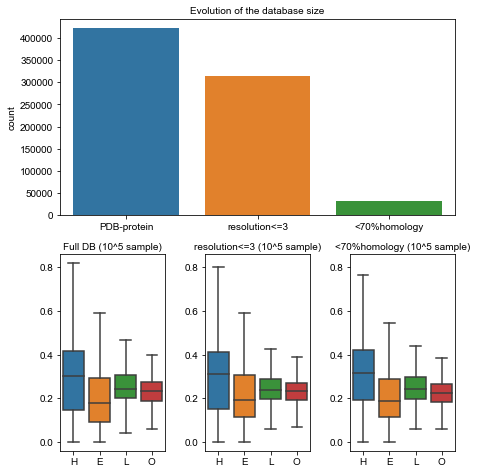

In [5]:
fig  = plt.figure(figsize=(170 / 25.4, 170 / 25.4))
grid = (2, 3)

# Count proteins in each database iteration
ax = plt.subplot2grid(grid, (0, 0), fig=fig, colspan=3)
sns.barplot(x="id", y="count", data=cnt, ax=ax)
rs.utils.add_top_title(ax, 'Evolution of the database size')
ax.set_xlabel('')

# Secondary structure content in each database iteration
ax = plt.subplot2grid(grid, (1, 0), fig=fig)
sns.boxplot(data=dfsse, ax=ax, order=['structure_A_H', 'structure_A_E', 'structure_A_L', 'structure_A_O'],
            showfliers=False)
rs.utils.add_top_title(ax, 'Full DB (10^5 sample)')
ax.set_xticklabels(['H', 'E', 'L', 'O'])
ax = plt.subplot2grid(grid, (1, 1), fig=fig, sharey=ax)
sns.boxplot(data=ddsse, ax=ax, order=['structure_A_H', 'structure_A_E', 'structure_A_L', 'structure_A_O'],
            showfliers=False)
rs.utils.add_top_title(ax, 'resolution<=3 (10^5 sample)')
ax.set_xticklabels(['H', 'E', 'L', 'O'])
ax = plt.subplot2grid(grid, (1, 2), fig=fig, sharey=ax)
sns.boxplot(data=dgsse, ax=ax, order=['structure_A_H', 'structure_A_E', 'structure_A_L', 'structure_A_O'],
            showfliers=False)
rs.utils.add_top_title(ax, '<70%homology (10^5 sample)')
ax.set_xticklabels(['H', 'E', 'L', 'O'])
plt.tight_layout()
plt.show()

Working SSE: LLLLLLLLLLLLTTLLLLGGGHHHHHHHHHHHHHHHHHHHHHTTLEELSSLBTTTTEETTLSLGGGLLHHHHHHHHHHHHHHHHHHHHTTLEEEELSLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLTTLLLLHHHHHHHHHHHHHHHHHHHHHHHHHHHHHTLLLLTTLSLGGGSLHHHHHHHHHHHHHHHHHHHHTTEEEELL
H positions: 21-41,68-87,138-166,182-201
Sequence segments: DSFINKFAEYTHEKWAFDKIQ
Sequence segments: EKDKEIYRWPIKESLKAMIA
Sequence segments: RELQAMAEQLAENYHNTWGRKKKQELEAK
Sequence segments: AKEKARDREKAQELLKFLQM
All AA: ['D', 'S', 'F', 'I', 'N', 'K', 'F', 'A', 'E', 'Y', 'T', 'H', 'E', 'K', 'W', 'A', 'F', 'D', 'K', 'I', 'Q', 'E', 'K', 'D', 'K', 'E', 'I', 'Y', 'R', 'W', 'P', 'I', 'K', 'E', 'S', 'L', 'K', 'A', 'M', 'I', 'A', 'R', 'E', 'L', 'Q', 'A', 'M', 'A', 'E', 'Q', 'L', 'A', 'E', 'N', 'Y', 'H', 'N', 'T', 'W', 'G', 'R', 'K', 'K', 'K', 'Q', 'E', 'L', 'E', 'A', 'K', 'A', 'K', 'E', 'K', 'A', 'R', 'D', 'R', 'E', 'K', 'A', 'Q', 'E', 'L', 'L', 'K', 'F', 'L', 'Q', 'M']
AA frequencies for H:


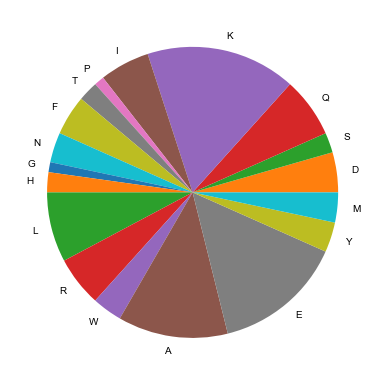

In [6]:
# To extract sequence depending on the SSE type, we will exploit rstoolbox selection system.
# (Normally this system does not need to be accessed directly)
# First, lets see an example with only one chain:

example = dg.iloc[0]
print('Working SSE:', example['structure_A'])
# np.where brings all indexes where the condition is fullfilled
Hsele = rs.components.Selection(np.where(np.array(list(example['structure_A'])) == 'H')[0])
print('H positions:', Hsele)
seqs = []
for selection in Hsele.to_string().split(','):
    # itemgetter: for a given list of positions, return the values of those positions
    seqs.append(itemgetter(*rs.components.get_selection(selection, 'A'))(list(example['sequence_A'])))
    print('Sequence segments:', ''.join(seqs[-1]))
seqs = [item for sublist in seqs for item in sublist]
print('All AA:', seqs)
print('AA frequencies for H:')
fig  = plt.figure(figsize=(170 / 25.4, 170 / 25.4))
grid = (1, 1)
ax = plt.subplot2grid(grid, (0, 0), fig=fig)
ax = rs.components.DesignFrame(seqs, columns=['sequence_A']).sequence_frequencies('A').T.plot.pie(y=1, ax=ax)
ax.set_ylabel('')
ax.get_legend().remove()

In [7]:
# We can run this now for the entire DB
# (We will run a 10% sample of the entire DB, to save time)

def get_sse_frqs(row):
    def get1sse(row, sse):
        qury = []
        if sse != '*':
            sele = rs.components.Selection(np.where(np.array(list(row['structure_A'])) == sse)[0])
            if sele.to_string() != '':
                qury = itemgetter(*rs.components.get_selection(sele, 'A'))(list(row['sequence_A']))
        else:
            qury = list(row['sequence_A'])
        return rs.components.DesignFrame(list(qury), columns=['sequence_A']).sequence_frequencies('A')
        
    return get1sse(row, 'H'), get1sse(row, 'E'), get1sse(row, 'L'), get1sse(row, '*')

sse_frq = dg.sample(frac=0.1).apply(get_sse_frqs, axis=1, result_type='reduce').tolist()
SSE = (pd.concat([rs.components.SequenceFrame(pd.concat([x[0] for x in sse_frq], sort=False).mean()).T,
                  rs.components.SequenceFrame(pd.concat([x[1] for x in sse_frq], sort=False).mean()).T,
                  rs.components.SequenceFrame(pd.concat([x[2] for x in sse_frq], sort=False).mean()).T,
                  rs.components.SequenceFrame(pd.concat([x[3] for x in sse_frq], sort=False).mean()).T],
                 sort=False)
       .drop(columns='sequence_A').reset_index(drop=True))

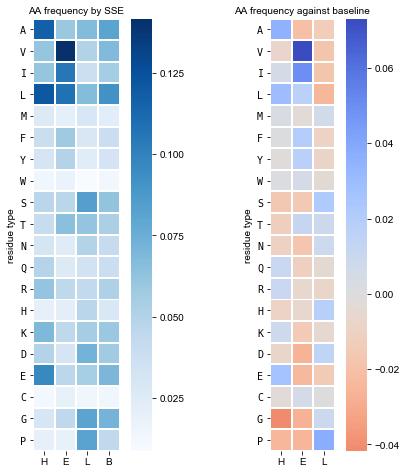

In [28]:
# Column B for 'baseline': not separated by SSE type
fig  = plt.figure(figsize=(170 / 25.4, 170 / 25.4))
grid = (1, 2)
ax = plt.subplot2grid(grid, (0, 0), fig=fig)

# Plot the AA frequency data with rstoolbox-provided plotting functions
rs.plot.sequence_frequency_plot(SSE, 'A', ax=ax, refseq=False, cbar_kws={"orientation": "vertical"})
ax.set_xticklabels(['H', 'E', 'L', 'B'])
rs.utils.add_top_title(ax, 'AA frequency by SSE')

# Plot the AA difference for SSE againts the background AA distribution
ax = plt.subplot2grid(grid, (0, 1), fig=fig)
rs.plot.sequence_frequency_plot((SSE - SSE.iloc[3]).iloc[:3], 'A', ax=ax, refseq=False,
                                cbar_kws={"orientation": "vertical"}, cmap="coolwarm_r", center=0)
ax.set_xticklabels(['H', 'E', 'L'])
rs.utils.add_top_title(ax, 'AA frequency against baseline')
plt.tight_layout()
plt.show()

In [22]:
# Generating the AAindex-like tables:
print('H:', SSE.iloc[0].to_dict(), '\n\n')
print('E:', SSE.iloc[1].to_dict(), '\n\n')
print('L:', SSE.iloc[2].to_dict())

# From a design perspective, we could compare these dictionaries with those present in the AAindex to see if
# our designs would compare in terms of SSE AA-type enrichment.

H: {'C': 0.011788394400015847, 'D': 0.049697580833935315, 'S': 0.04681469407266296, 'Q': 0.04916771625076914, 'K': 0.06869189718658572, 'I': 0.06135514839852591, 'P': 0.020235833956902344, 'T': 0.040864285175199404, 'F': 0.039136962611236864, 'N': 0.03190588307077263, 'G': 0.030349202631069428, 'H': 0.019913636547431574, 'L': 0.12128381884943525, 'R': 0.06188341359319477, 'W': 0.014029003913989925, 'A': 0.11681274930832802, 'V': 0.06139365904727392, 'E': 0.0960193222781065, 'Y': 0.03163936038310033, 'M': 0.02697746360773528} 


E: {'C': 0.019399722612977288, 'D': 0.03126289435102479, 'S': 0.047061418024111144, 'Q': 0.026572078519108377, 'K': 0.045236195207801706, 'I': 0.10561727945185628, 'P': 0.019457275696217014, 'T': 0.06492612500860107, 'F': 0.0584021558755918, 'N': 0.024713610054506768, 'G': 0.04507592069034104, 'H': 0.0226649175247602, 'L': 0.10841637134923514, 'R': 0.04533591314373223, 'W': 0.017198135765881396, 'A': 0.06012175807669766, 'V': 0.1416532924971732, 'E': 0.046263535